In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.autograd import Variable
import torch.utils.data as data
import cv2
from tqdm import tqdm
import sys
from os import listdir
from os.path import join
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [ ]:
# Image resize

def load_image(png_file_path):
        img_rgb = cv2.imread(png_file_path)
        img_grey = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
        img_adapted = cv2.adaptiveThreshold(img_grey, 255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY, 101, 9)
        img_stacked = np.repeat(img_adapted[...,None],3,axis=2)
        resized = cv2.resize(img_stacked, (224,224), interpolation=cv2.INTER_AREA)
        bg_img = 255 * np.ones(shape=(224,224,3))
        bg_img[0:224, 0:224,:] = resized
        bg_img /= 255
        bg_img = np.rollaxis(bg_img, 2, 0)  
        return bg_img
    

def load_doc(filename):
    with open(filename, 'r') as f:
        text = f.read()
    return text.strip()

# Initialsieren Dataset für Sketch to Code

class SketchToCodeDataset():
    def __init__(self, data_dir, input_transform=None, target_transform=None):
        self.data_dir = data_dir
        self.image_filenames = []
        self.texts = []
        all_filenames = listdir(data_dir)
        all_filenames.sort()
        for filename in all_filenames:
            if filename.endswith(".png"):
                self.image_filenames.append(filename)
            elif filename.endswith(".gui"):
                text = '<START> ' + load_doc(self.data_dir+filename) + ' <END>'
                text = ' '.join(text.split())
                text = text.replace(',', ' ,')
                self.texts.append(text)
        self.input_transform = input_transform
        self.target_transform = target_transform
        
         # Initialize the function to create the vocabulary 
        tokenizer = Tokenizer(filters='', split=" ", lower=False)
        
        # Create the vocabulary 
        tokenizer.fit_on_texts([load_doc('vocabulary.vocab')])
        self.tokenizer = tokenizer
        
        # Add one spot for the empty word in the vocabulary 
        self.vocab_size = len(tokenizer.word_index) + 1
        
        # Map the input sentences into the vocabulary indexes
        self.train_sequences = tokenizer.texts_to_sequences(self.texts)
        
        # The longest set of boostrap tokens
        self.max_sequence = max(len(s) for s in self.train_sequences)
        
        # Specify how many tokens to have in each input sentence
        self.max_length = 48

        X, y, image_data_filenames = list(), list(), list()
        for img_no, seq in enumerate(self.tokenizer.texts_to_sequences(self.texts)):
            in_seq, out_seq = seq[:-1], seq[1:]
            out_seq = to_categorical(out_seq, num_classes=self.vocab_size)
            image_data_filenames.append(self.image_filenames[img_no])
            X.append(in_seq)
            y.append(out_seq)

        self.X = list(X)
        self.y = list(y)
        self.image_data_filenames = image_data_filenames
        self.images = list()
        for image_name in self.image_data_filenames:
            image = load_image(self.data_dir+image_name)
            if self.input_transform is not None:
                image = self.input_transform(image)
            self.images.append(image)      

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('This Computation is running on {}'.format(device))

This Computation is running on cuda:0


# Load Date

In [ ]:
dir_name = '/content/drive/MyDrive/projects/sketch2code/data/all_data/data/'
batch_size = 32
my_dateset = SketchToCodeDataset(dir_name)


# Model

In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet34(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        self.init_weights()
        
    def init_weights(self):
        """Initialize the weights."""
        self.linear.weight.data.normal_(0.0, 0.02)
        self.linear.bias.data.fill_(0)
        
    def forward(self, images):
        """Extract the image feature vectors."""
        features = self.resnet(images)
        features = Variable(features.data)
        features = features.view(features.size(0), -1)
        if images.shape[0] < 2:
            features = self.linear(features)
            return features
        features = self.bn(self.linear(features))
        return features # Bxembed_size

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.n_layers = num_layers
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.GRU(embed_size*2, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        """Initialize weights."""
        self.embed.weight.data.uniform_(-0.1, 0.1)
        self.linear.weight.data.uniform_(-0.1, 0.1)
        self.linear.bias.data.fill_(0)
        
    def forward(self, features, captions, hidden):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1).repeat(1,embeddings.shape[1],1), embeddings), 2)
        output, hidden = self.lstm(embeddings, hidden)
        outputs = self.linear(output)
        return outputs, hidden
        print(outputs, hidden)
    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [ ]:
# Hyperparameter
embed_size = 50
hidden_size = 256
num_layers = 3
num_epochs = 30

encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, my_dateset.vocab_size, num_layers)
criterion = nn.MSELoss()


In [ ]:
encoder = encoder.to(device)
decoder = decoder.to(device)
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params,lr=0.001)

In [ ]:
losses = []
epochs = []
for epoch in tqdm(range(num_epochs)):
    for i_batch in range(len(my_dateset.X)):
        hidden = decoder.init_hidden()
        images = Variable(torch.FloatTensor([my_dateset.images[i_batch]]))
        input_seqs = Variable(torch.LongTensor(my_dateset.X[i_batch])).view(1,-1)
        target_seq = Variable(torch.FloatTensor(my_dateset.y[i_batch]))
        input_seqs = input_seqs.to(device)
        images = images.to(device)
        hidden = hidden.to(device)
        target_seq =  target_seq.to(device)
        encoder.zero_grad()
        decoder.zero_grad()
        features = encoder(images)
        outputs, hidden = decoder(features, input_seqs, hidden)
        loss = 0
        for di in range(target_seq.shape[0]):
            loss += criterion(outputs.squeeze(0)[di], target_seq[di])
        
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        epochs.append(epoch + i_batch/len(my_dateset.X))

    print('Epoch [%d/%d], Loss: %.4f'
       %(epoch+1, num_epochs,
       loss.item())) 
    
    torch.save(encoder,'encoder_resnet34_'+str(loss.item())+'.pt')
    torch.save(decoder,'decoder_resnet34_'+str(loss.item())+'.pt')

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-13-9e7b351a1c4e>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = Variable(torch.FloatTensor([my_dateset.images[i_batch]]))


Epoch [1/30], Loss: 0.2360


  3%|▎         | 1/30 [00:58<28:19, 58.61s/it]

Epoch [2/30], Loss: 0.2022


  7%|▋         | 2/30 [01:54<26:29, 56.76s/it]

Epoch [3/30], Loss: 0.2591


 10%|█         | 3/30 [02:47<24:57, 55.45s/it]

Epoch [4/30], Loss: 0.1702


 13%|█▎        | 4/30 [03:42<23:52, 55.08s/it]

Epoch [5/30], Loss: 0.1297


 17%|█▋        | 5/30 [04:36<22:46, 54.65s/it]

Epoch [6/30], Loss: 0.1255


 20%|██        | 6/30 [05:30<21:44, 54.36s/it]

Epoch [7/30], Loss: 0.2025


 23%|██▎       | 7/30 [06:24<20:52, 54.44s/it]

Epoch [8/30], Loss: 0.1751


 27%|██▋       | 8/30 [07:19<19:58, 54.47s/it]

Epoch [9/30], Loss: 0.1009


 30%|███       | 9/30 [08:14<19:06, 54.62s/it]

Epoch [10/30], Loss: 0.1720


 33%|███▎      | 10/30 [09:09<18:16, 54.83s/it]

Epoch [11/30], Loss: 0.1374


 37%|███▋      | 11/30 [10:05<17:30, 55.29s/it]

Epoch [12/30], Loss: 0.1574


 40%|████      | 12/30 [11:01<16:35, 55.32s/it]

Epoch [13/30], Loss: 0.0852


 43%|████▎     | 13/30 [11:56<15:37, 55.16s/it]

Epoch [14/30], Loss: 0.1693


 47%|████▋     | 14/30 [12:51<14:43, 55.20s/it]

Epoch [15/30], Loss: 0.1220


 50%|█████     | 15/30 [13:47<13:52, 55.50s/it]

Epoch [16/30], Loss: 0.0943


 53%|█████▎    | 16/30 [14:42<12:53, 55.28s/it]

Epoch [17/30], Loss: 0.1460


 57%|█████▋    | 17/30 [15:38<12:01, 55.53s/it]

Epoch [18/30], Loss: 0.1359


 60%|██████    | 18/30 [16:33<11:06, 55.52s/it]

Epoch [19/30], Loss: 0.0689


 63%|██████▎   | 19/30 [17:28<10:07, 55.25s/it]

Epoch [20/30], Loss: 0.1324


 67%|██████▋   | 20/30 [18:22<09:09, 54.96s/it]

Epoch [21/30], Loss: 0.1720


 70%|███████   | 21/30 [19:18<08:17, 55.25s/it]

Epoch [22/30], Loss: 0.1010


 73%|███████▎  | 22/30 [20:13<07:21, 55.16s/it]

Epoch [23/30], Loss: 0.0942


 77%|███████▋  | 23/30 [21:08<06:25, 55.03s/it]

Epoch [24/30], Loss: 0.0655


 80%|████████  | 24/30 [22:02<05:28, 54.81s/it]

Epoch [25/30], Loss: 0.0724


 83%|████████▎ | 25/30 [22:58<04:34, 54.99s/it]

Epoch [26/30], Loss: 0.0692


 87%|████████▋ | 26/30 [23:53<03:40, 55.00s/it]

Epoch [27/30], Loss: 0.1620


 90%|█████████ | 27/30 [24:47<02:44, 54.89s/it]

Epoch [28/30], Loss: 0.1196


 93%|█████████▎| 28/30 [25:42<01:49, 54.86s/it]

Epoch [29/30], Loss: 0.0791


 97%|█████████▋| 29/30 [26:36<00:54, 54.69s/it]

Epoch [30/30], Loss: 0.0606


100%|██████████| 30/30 [27:31<00:00, 55.04s/it]


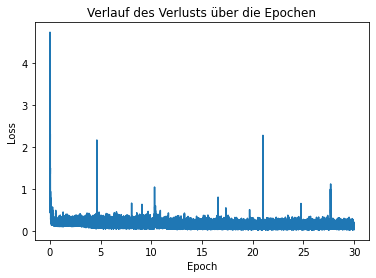

In [ ]:


# Convert tensors to numpy arrays
losses = np.array(losses)
epochs = np.array(epochs)

# Convert tensors to numpy arrays
losses = np.array(losses)
epochs = np.array(epochs)

# Plot the loss vs. epoch (with numpy arrays)
plt.plot(epochs, losses)
plt.title('Verlauf des Verlusts über die Epochen')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()






In [ ]:
decoder = torch.load('decoder_resnet34_0.060610368847846985.pt')
encoder = torch.load('encoder_resnet34_0.060610368847846985.pt')

In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def load_val_images(data_dir):
    image_filenames =[]
    images = []
    all_filenames = listdir(data_dir)
    all_filenames.sort()
    for filename in (all_filenames):
        if filename[-3:] == "png":
            image_filenames.append(filename)
    for name in image_filenames:
        image = load_image(data_dir+name)
        images.append(image)
    return images

In [ ]:
decoded_words = []
star_text = '<START> '
hidden = decoder.init_hidden()
image = load_val_images('val/')[0]
image = Variable(torch.FloatTensor([image]))
image = image.to(device)
predicted = '<START> '
for di in range(9999):
    sequence = my_dateset.tokenizer.texts_to_sequences([star_text])[0]
    decoder_input = Variable(torch.LongTensor(sequence)).view(1,-1)
    features = encoder(image)
    #print(decoder_input)
    decoder_input = decoder_input.to(device)
    hidden = hidden.to(device)

    outputs,hidden = decoder(features, decoder_input,hidden)
    topv, topi = outputs.data.topk(1)
    ni = topi[0][0][0]
    word = word_for_id(ni,my_dateset.tokenizer)
    if word is None:
            continue
    predicted += word + ' '
    star_text = word
    print(predicted)
    if word == '<END>':
            break

<START> header 
<START> header { 
<START> header { btn-inactive 
<START> header { btn-inactive , 
<START> header { btn-inactive , btn-inactive 
<START> header { btn-inactive , btn-inactive , 
<START> header { btn-inactive , btn-inactive , btn-inactive 
<START> header { btn-inactive , btn-inactive , btn-inactive , 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { 
<START> header { btn-inactive , btn-inactive , btn-inactive , btn-inactive , btn-inactive } row { quadruple 
<START> header { btn-inactive , btn-inact

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

original_gui = load_doc('val/2BC033FD-F097-463B-98A8-C1C9CE50B478.gui')
original_gui = ' '.join(original_gui.split())
original_gui = original_gui.replace(',', ' ,')
original_gui = original_gui.split()

# Predicted images don't have color so we normalize all buttons to btn-orange or btn-active
btns_to_replace = ['btn-green', 'btn-red']
normalized_original_gui = ['btn-orange' if token in btns_to_replace else token for token in original_gui]
normalized_original_gui = ['btn-active' if token == 'btn-inactive' else token for token in normalized_original_gui]

generated_gui = predicted.split()

normalized_generated_gui = ['btn-orange' if token in btns_to_replace else token for token in generated_gui]
normalized_generated_gui = ['btn-active' if token == 'btn-inactive' else token for token in normalized_generated_gui]

#BLEU score 
print(sentence_bleu([normalized_original_gui],normalized_generated_gui))

0.9741881046090399


In [ ]:
from inference.Compiler import *

In [ ]:
compiler = Compiler('default')
compiled_website = compiler.compile(predicted.split())

In [ ]:
#generated HTML
print(compiled_website)

<html>
  <header>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css" integrity="sha384-BVYiiSIFeK1dGmJRAkycuHAHRg32OmUcww7on3RYdg4Va+PmSTsz/K68vbdEjh4u" crossorigin="anonymous">
<link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap-theme.min.css" integrity="sha384-rHyoN1iRsVXV4nD0JutlnGaslCJuC7uwjduW9SVrLvRYooPp2bWYgmgJQIXwl/Sp" crossorigin="anonymous">
<style>
.header{margin:20px 0}nav ul.nav-pills li{background-color:#333;border-radius:4px;margin-right:10px}.col-lg-3{width:24%;margin-right:1.333333%}.col-lg-6{width:49%;margin-right:2%}.col-lg-12,.col-lg-3,.col-lg-6{margin-bottom:20px;border-radius:6px;background-color:#f5f5f5;padding:20px}.row .col-lg-3:last-child,.row .col-lg-6:last-child{margin-right:0}footer{padding:20px 0;text-align:center;border-top:1px solid #bbb}
</style>
    <title>Scaffol